In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

sentences = ["there is a shortage of capital, and we need extra financing", 
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]

inputs = tokenizer(sentences, return_tensors="pt", padding=True)
outputs = finbert(**inputs)[0]

labels = {0:'neutral', 1:'positive',2:'negative'}
for idx, sent in enumerate(sentences):
    print(sent, '----', labels[np.argmax(outputs.detach().numpy()[idx])])

    

/home/az2482/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


there is a shortage of capital, and we need extra financing ---- negative
growth is strong and we have plenty of liquidity ---- positive
there are doubts about our finances ---- negative
profits are flat ---- neutral


<Axes: title={'center': 'Average Sentiment by Day'}, xlabel='created_utc'>

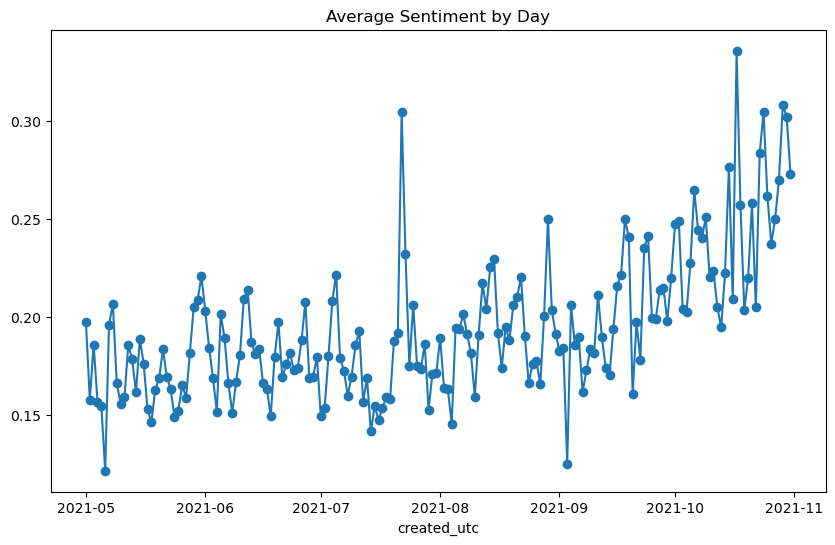

In [3]:
import pandas as pd
from datetime import datetime

# Read the CSV file and convert 'created_utc' to datetime
r_data = pd.read_csv('six-months-of-gme-on-reddit-comments.csv')
r_data['created_utc'] = pd.to_datetime(r_data['created_utc'], unit='s')

# Group by day, calculate average sentiment, and plot
r_data.groupby(r_data['created_utc'].dt.date)['sentiment'].mean().plot(kind='line', marker='o', figsize=(10, 6), title='Average Sentiment by Day')


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load dataset
r_data = pd.read_csv('six-months-of-gme-on-reddit-comments.csv')

# Convert 'created_utc' to DateTime format
r_data['created_utc'] = pd.to_datetime(r_data['created_utc'], unit='s')

# Extract date from 'created_utc' and store it in a new column
r_data['date'] = r_data['created_utc'].dt.date
r_data=r_data.dropna()

# Group by date
grouped_data = r_data.groupby('date')

sampled_data_list = []

# Iterate over each group (date)
for date, group in grouped_data:
    # Take a random sample of 30 rows for each date
    sampled_group = group.sample(n=30, random_state=42)  # Adjust random_state as needed for reproducibility
    # Append the sampled group to the list
    sampled_data_list.append(sampled_group)

# Concatenate all sampled dataframes into one dataframe
sampled_data = pd.concat(sampled_data_list, ignore_index=True)

# Display the sampled_data DataFrame
# print(sampled_data)



5520


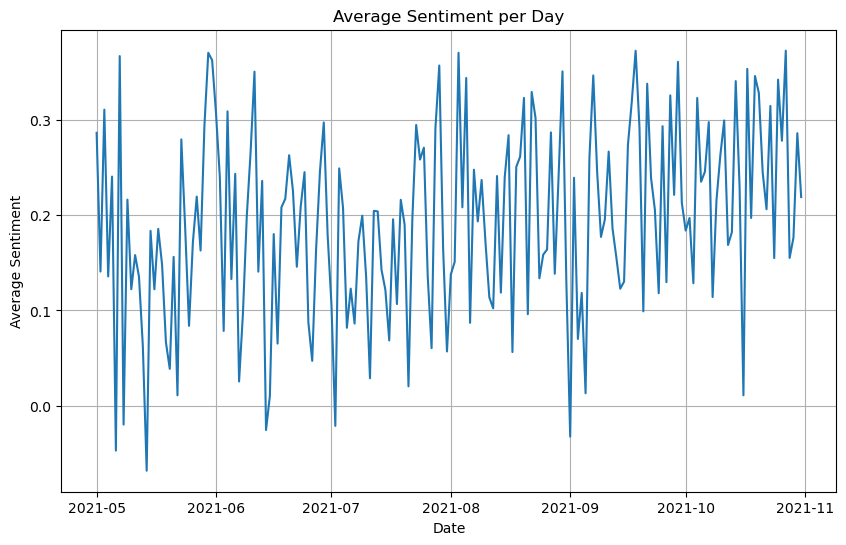

In [5]:
print(len(sampled_data))
import matplotlib.pyplot as plt

# Assuming 'sentiment' is the column representing sentiment scores

# Group by date and calculate the mean sentiment for each day
mean_sentiment_per_day = sampled_data.groupby('date')['sentiment'].mean()

# Plotting
plt.figure(figsize=(10, 6))
mean_sentiment_per_day.plot()
plt.title('Average Sentiment per Day')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


In [6]:
import re
import string
from datetime import datetime
# r_data = pd.read_csv('six-months-of-gme-on-reddit-comments.csv', nrows=5000)

def label_sentiment(sentiment):
    if sentiment < 0:
        return "neg"
    elif sentiment == 0:
        return "neu"
    else:
        return "pos"

sampled_data['sentiment_label'] = sampled_data['sentiment'].apply(lambda x: label_sentiment(x))
# REMOVE ROWS THAT HAVE NA

# processing the text
sampled_data.body = sampled_data.body.str.lower()
sampled_data.body = sampled_data.body.apply(lambda x:re.sub('@[^\s]+','',x))
sampled_data.body = sampled_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))
sampled_data['body'] = sampled_data['body'].apply(lambda x: ' '.join(re.findall(r'\b\w{2,}\b', x)))
sampled_data['body'] = sampled_data['body'].apply(lambda x: re.sub(r'[\U00010000-\U0010ffff]', '', x))

# r_data['sentiment_label'] = r_data['sentiment'].apply(label_sentiment)
# Display the DataFrame with the new column
new_df = sampled_data[['created_utc', 'body', 'sentiment_label']].copy()

print(new_df.head(10))


          created_utc                                               body  \
0 2021-05-01 02:46:47  that the way my ape we ll hope for the price t...   
1 2021-05-01 14:32:40  this brings me back to the post the other day ...   
2 2021-05-01 19:10:14  suppose this isn the place to debate the gme s...   
3 2021-05-01 05:16:22  if you think the gme squeeze can still happen ...   
4 2021-05-01 23:28:39  ve been using the paper trading with everythin...   
5 2021-05-01 18:09:08  just another gme hoe fr no offense taken am an...   
6 2021-05-01 15:14:50  the vw squeeze lasted around week there are si...   
7 2021-05-01 05:05:49  the pie looks almost identical to the pie in y...   
8 2021-05-01 15:28:48  will hold minimum share through everything but...   
9 2021-05-01 21:16:12  think read somewhere that they had short inter...   

  sentiment_label  
0             pos  
1             pos  
2             pos  
3             neu  
4             neg  
5             pos  
6             pos  
7  

In [7]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
max_input_length = tokenizer.model_max_length
print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

3 4 0 2


In [8]:
import torch
import random
from torchtext.data import Field, LabelField, Dataset,BucketIterator, Example
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# Define fields
TEXT = Field(batch_first=True,
             use_vocab=False,
             tokenize=tokenize_and_cut,  # Assuming you have defined this function
             preprocessing=tokenizer.convert_tokens_to_ids,  # Assuming you have defined this function
             init_token=init_token_idx,
             eos_token=eos_token_idx,
             pad_token=pad_token_idx,
             unk_token=unk_token_idx)

LABEL = LabelField(dtype=torch.float)

# Convert DataFrame rows to tuples of text and label
# data_tuples = [(row['body'], row['sentiment_label']) for index, row in new_df.iterrows()]

# Create Dataset objects from tuples
# dataset = Dataset(data_tuples, fields=[('text', TEXT), ('label', LABEL)])
# Define custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, fields, **kwargs):
        examples = [Example.fromlist(item, fields) for item in data]
        super(CustomDataset, self).__init__(examples, fields, **kwargs)

# Create Dataset object
# fields = [('text', TEXT), ('label', LABEL)]
# dataset = CustomDataset(data_tuples, fields)
# LABEL.build_vocab(dataset)

fields = [('text', TEXT), ('label', LABEL)]
data_tuples = [(row['body'], row['sentiment_label']) for index, row in new_df.iterrows()]
dataset = CustomDataset(data_tuples, fields)


LABEL.build_vocab(dataset)

train_data, test_data = dataset.split(split_ratio=0.8)  # Adjust split_ratio as needed
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [9]:
# Display all field names in the dataset
for field_name, field in dataset.fields.items():
    print(f"Field Name: {field_name}")
    print(f"Field Object: {field}")


Field Name: text
Field Object: <torchtext.data.field.Field object at 0x15299642a310>
Field Name: label
Field Object: <torchtext.data.field.LabelField object at 0x15292554f6d0>


In [10]:
print(LABEL.vocab.stoi)

defaultdict(None, {'pos': 0, 'neg': 1, 'neu': 2})


In [11]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)
device
for batch in train_iterator:
    text_data = batch.text
    labels = batch.label
    print("Text data shape:", text_data.shape)
    print("Labels shape:", labels.shape)


Text data shape: torch.Size([128, 429])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 629])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 976])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 2253])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 2246])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 778])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 2240])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 2214])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 367])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 2260])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 614])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 309])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 794])
Labels shape: torch.Size([128])
Text data shape: torch.Size([128, 673])
Labels shape: torch

In [12]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, BertTokenizer

class BERTGRUSentiment(nn.Module):
    def __init__(self, bert, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()

        self.bert = bert
        embedding_dim = bert.config.hidden_size

        self.rnn = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=0 if n_layers < 2 else dropout
        )

        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # input_ids = [batch size, sent len]
        with torch.no_grad():
            # Get the embeddings from the BERT model
            outputs = self.bert.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            embedded = outputs.last_hidden_state
        
        # embedded = [batch size, sent len, emb dim]
        _, hidden = self.rnn(embedded)
        
        # hidden = [n layers * n directions, batch size, emb dim]
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])
        
        # hidden = [batch size, hid dim]
        output = self.out(hidden)
        # output = [batch size, out dim]
        return output

# Initialize BERT and the tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Create an instance of the modified BERTGRUSentiment model
hidden_dim = 256
output_dim = 3
n_layers = 2
bidirectional = True
dropout = 0.3

model = BERTGRUSentiment(finbert, hidden_dim, output_dim, n_layers, bidirectional, dropout)


/home/az2482/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("The number of trainable parameters of the model are: " + str(count_parameters(model)))


The number of trainable parameters of the model are: 112514310


In [14]:
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False
print("The number of non-frozen trainable parameters of the model are: " + str(count_parameters(model)))


The number of non-frozen trainable parameters of the model are: 2760195


In [15]:
import torch.optim as optim

def binary_accuracy(preds, y):

    # Q3a. Compute accuracy (as a number between 0 and 1)

    # ...
    rounded_predictions = torch.round(torch.sigmoid(preds))
    # calculating the accuracy
    true_predictions = (rounded_predictions == y).float()
    acc = true_predictions.sum() / len(true_predictions)

    return ACC
def multi_class_accuracy(preds, y):
    _, predicted_labels = torch.max(preds, 1)  # Choose the class with the highest probability as the predicted label
    correct_predictions = (predicted_labels == y).float()  # Convert boolean to float (1 if correct prediction, 0 otherwise)
    acc = correct_predictions.sum() / len(correct_predictions)  # Calculate accuracy
    return acc
def train(model, iterator, optimizer, criterion):

    # Q3b. Set up the training function

    # ...
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()

        text, labels = batch.text, batch.label
        predictions = model(text).squeeze(1)

        loss = criterion(predictions, labels)
        acc = multi_class_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()


    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def evaluate(model, iterator, criterion):

    # Q3c. Set up the evaluation function.

    # ...

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for it in iterator:
            # Extract labels
            text, labels = it.text, it.label
            predictions = model(text).squeeze(1) # forward pass

            loss = criterion(predictions, labels)
            accuracy = multi_class_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += accuracy.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
train_data[0].label

'neu'

In [17]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
train_iterator

In [18]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time =  time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = int((end_time - start_time) / 60), int((end_time - start_time) % 60)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


RuntimeError: The expanded size of the tensor (2240) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [128, 2240].  Tensor sizes: [1, 512]

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
import torch
import random
from torchtext.data import Field, LabelField, Dataset,BucketIterator
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# Define fields
TEXT = Field(batch_first=True,
             use_vocab=False,
             tokenize=tokenize_and_cut,  # Assuming you have defined this function
             preprocessing=tokenizer.convert_tokens_to_ids,  # Assuming you have defined this function
             init_token=init_token_idx,
             eos_token=eos_token_idx,
             pad_token=pad_token_idx,
             unk_token=unk_token_idx)

LABEL = LabelField(dtype=torch.float)

# Convert DataFrame rows to tuples of text and label
data_tuples = [(row['body'], row['sentiment_label']) for index, row in new_df.iterrows()]

# Create Dataset objects from tuples
dataset = Dataset(data_tuples, fields=[('text', TEXT), ('label', LABEL)])

# Split dataset into train and test datasets
train_data, test_data = dataset.split(split_ratio=0.8)  # Adjust split_ratio as needed

train_data, valid_data = train_data.split(random_state = random.seed(SEED))
TEXT.preprocess(dataset[0])

In [ ]:
import re
import string
from datetime import datetime
# r_data = pd.read_csv('six-months-of-gme-on-reddit-comments.csv', nrows=5000)
r_data = pd.read_csv('six-months-of-gme-on-reddit-comments.csv')
r_data = r_data.sample(frac=1).reset_index(drop=True)
r_data = r_data.head(5000)
# r_data = r_data[pd.to_datetime(r_data.timestamp).dt.year>=2021]÷
def label_sentiment(sentiment):
    if sentiment < 0:
        return "neg"
    elif sentiment == 0:
        return "neu"
    else:
        return "pos"

r_data['sentiment_label'] = r_data['sentiment'].apply(lambda x: label_sentiment(x))
# REMOVE ROWS THAT HAVE NA

# processing the text
r_data.body = r_data.body.str.lower()
r_data.body = r_data.body.apply(lambda x:re.sub('@[^\s]+','',x))
r_data.body = r_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))
r_data['body'] = r_data['body'].apply(lambda x: ' '.join(re.findall(r'\b\w{2,}\b', x)))
r_data['body'] = r_data['body'].apply(lambda x: re.sub(r'[\U00010000-\U0010ffff]', '', x))



In [ ]:
import pandas as pd
from datetime import datetime

# Read the CSV file and convert 'created_utc' to datetime
r_data['graph_utc'] = pd.to_datetime(r_data['created_utc'], unit='s')

# Group by day, calculate average sentiment, and plot
r_data.groupby(r_data['graph_utc'].dt.date)['sentiment'].mean().plot(kind='line', marker='o', figsize=(10, 6), title='Average Sentiment by Day')


In [ ]:

r_data['created_utc'] = r_data['created_utc'].apply(lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))

# r_data['sentiment_label'] = r_data['sentiment'].apply(label_sentiment)
# Display the DataFrame with the new column
new_df = r_data[['created_utc', 'body', 'sentiment_label']].copy()

print(r_data.head(10))

In [ ]:
print(len(r_data))

In [ ]:
print(r_data.columns)


In [ ]:

# Print the new DataFrame
print(new_df.head(10))

In [ ]:
token_lens = []

for txt in new_df['body'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

In [ ]:
new_df['sentiment_label'].value_counts()

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
 !pip install torchtext==0.6

In [ ]:
import torch
from torchtext.data import Field, LabelField, Dataset

# Define fields
TEXT = Field(batch_first=True,
             use_vocab=False,
             tokenize=tokenize_and_cut,  # Assuming you have defined this function
             preprocessing=tokenizer.convert_tokens_to_ids,  # Assuming you have defined this function
             init_token=init_token_idx,
             eos_token=eos_token_idx,
             pad_token=pad_token_idx,
             unk_token=unk_token_idx)

LABEL = LabelField(dtype=torch.float)

# Convert DataFrame rows to tuples of text and label
data_tuples = [(row['body'], row['sentiment_label']) for index, row in new_df.iterrows()]

# Create Dataset objects from tuples
dataset = Dataset(data_tuples, fields=[('text', TEXT), ('label', LABEL)])

# Split dataset into train and test datasets
train_data, test_data = dataset.split(split_ratio=0.8)  # Adjust split_ratio as needed
LABEL.build_vocab(train_data)

In [ ]:
# train_data.examples[0]